### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2021 Semester 2

## Assignment 2

**Student Name:**    JIAXIN FAN

**Student ID:**     `1163511

## This iPython notebook is a template which you should use for your Assignment 2 submission. This file should be submitted at the **Assignment 2: Code** link on the LMS.

In addition to this file, you should submit a writren report explaining your results at the **Assignment 2: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 2. Classification on the CIFAR-10 subset

In this problem, you will conduct classification on a subset of the CIFAR10 dataset. The dataset is generated in the following coding block (Please don't modify the following coding block).

1. Implement  the  CNN  shown  in  Q1  in  the  assignment specificication  and  use  it  to classify the provided dataset.  Plot the training accuracy and testing accuracy under different epochs. Please see the assignment specificication for more details of the training settings.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import keras
import math 
from scipy import ndimage 
from keras.layers.core import Layer
from keras.datasets import mnist
from keras.models import Sequential
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten




(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

train_images_sub=np.zeros([250,32,32,3])
train_labels_sub=np.zeros([250,1])

test_images_sub=np.zeros([200,32,32,3])
test_labels_sub=np.zeros([200,1])

for clsi in range (10):
    idx=train_labels==clsi
    idx=np.squeeze(idx)
    imgs = train_images[idx,:,:,:]
    imgs = imgs[::200,:,:,:]
    train_images_sub[25*clsi:(clsi+1)*25,:,:,:] = imgs
    train_labels_sub[25*clsi:(clsi+1)*25,:] = clsi
    
    idx=test_labels==clsi
    idx=np.squeeze(idx)
    imgs = test_images[idx,:,:,:]
    imgs = imgs[::50,:,:,:]
    test_images_sub[20*clsi:(clsi+1)*20,:,:,:]=imgs
    test_labels_sub[20*clsi:(clsi+1)*20,:] = clsi
    

print("train_images shape:", train_images_sub.shape)
print("train_labels shape:", train_labels_sub.shape)
print("test_images shape:", test_images_sub.shape)
print("test_labels shape:", test_labels_sub.shape)



train_images shape: (250, 32, 32, 3)
train_labels shape: (250, 1)
test_images shape: (200, 32, 32, 3)
test_labels shape: (200, 1)


In [3]:
kernel_init = keras.initializers.glorot_uniform()
## if bias value =0 means doesn't consider bias 
bias_init = keras.initializers.Constant(value=0.2)

In [4]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), strides=(1, 1),padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), strides=(1, 1),padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), strides=(1, 1),padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1),padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), strides=(1, 1),padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3,pool_proj],  name=name)
    
    return output

In [5]:
input_layer = Input(shape=(32, 32, 3))

x = Conv2D(32, (5, 5), strides=(1, 1), activation='relu', name='conv_layer', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)


x = inception_module(x,
                 filters_1x1=32,
                 filters_3x3_reduce=32,
                 filters_3x3=64,
                 filters_pool_proj=32,
                 name='module1')
x = inception_module(x,
                 filters_1x1=64,
                 filters_3x3_reduce=64,
                 filters_3x3=128,
                 filters_pool_proj=64,
                 name='module2')

x = MaxPool2D((2, 2), padding='same', strides=(2, 2), name='max_pool')(x)
x = Flatten()(x)
x = Dense(256, activation='relu', name='FC256')(x)
x = Dense(10, activation='softmax', name='FC10')(x)



In [6]:
model = Model(input_layer,x, name='myCNN')

In [7]:
model.summary()

Model: "myCNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv_layer (Conv2D)             (None, 28, 28, 32)   2432        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   1056        conv_layer[0][0]                 
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 28, 28, 32)   0           conv_layer[0][0]                 
______________________________________________________________________________________________

In [8]:
model.compile(optimizer='adam',
           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), #use SparseCategoricalCrossentropy because labels are integers. If the labels are one-hot representation, please use CategoricalCrossentropy loss.
           metrics=['accuracy'])

In [9]:
history_model = model.fit(train_images_sub, train_labels_sub, epochs=20, batch_size=32, 
                    validation_data=(test_images_sub, test_labels_sub))

Epoch 1/20
8/8 [==============================] - 20s 350ms/step - loss: 361.5140 - accuracy: 0.0911 - val_loss: 189.6765 - val_accuracy: 0.1000
Epoch 2/20
8/8 [==============================] - 2s 263ms/step - loss: 111.4553 - accuracy: 0.1063 - val_loss: 11.0423 - val_accuracy: 0.1200
Epoch 3/20
8/8 [==============================] - 2s 261ms/step - loss: 7.3642 - accuracy: 0.2317 - val_loss: 3.5640 - val_accuracy: 0.1550
Epoch 4/20
8/8 [==============================] - 2s 265ms/step - loss: 2.6052 - accuracy: 0.2374 - val_loss: 2.4366 - val_accuracy: 0.1450
Epoch 5/20
8/8 [==============================] - 2s 281ms/step - loss: 1.9325 - accuracy: 0.3102 - val_loss: 2.1803 - val_accuracy: 0.2300
Epoch 6/20
8/8 [==============================] - 3s 370ms/step - loss: 1.6185 - accuracy: 0.5026 - val_loss: 2.1923 - val_accuracy: 0.1750
Epoch 7/20
8/8 [==============================] - 3s 367ms/step - loss: 1.3675 - accuracy: 0.5793 - val_loss: 2.3065 - val_accuracy: 0.2400
Epoch 8/20
8

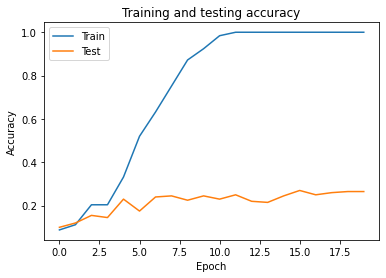

In [11]:
plt.plot(history_model.history ['accuracy'], label='Train')
plt.plot(history_model.history ['val_accuracy'], label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and testing accuracy')
plt.legend()
plt.show()

In [ ]:
The reason is that the numbers of training instances are too little ，Model is overfitting，
model is too close to the characteristics of the training data, 
not generalizable so testing accuracy is low, and there is also no bias for the convolution layers.

2. Implement the MLP model provided in Q2 in the assignment specificication and use it to classify the given dataset. Plot the training accuracy and testing accuracy under different epochs. Please see the assignment specificication for more details of the training settings.

In [12]:
input_layer = Input(shape=(32, 32, 3))
x = Flatten()(input_layer)
x = Dense(256, activation='relu', name='FC256')(x)
x = Dense(10, activation='softmax', name='FC10')(x)

In [13]:
MLP = Model(input_layer, x, name='mlp')

In [14]:
MLP.compile(optimizer='adam',
           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), #use SparseCategoricalCrossentropy because labels are integers. If the labels are one-hot representation, please use CategoricalCrossentropy loss.
           metrics=['accuracy'])

In [15]:
history_mlp = MLP.fit(train_images_sub, train_labels_sub, epochs=20, batch_size=32, 
                    validation_data=(test_images_sub, test_labels_sub))

Epoch 1/20
8/8 [==============================] - 1s 53ms/step - loss: 813.8353 - accuracy: 0.0722 - val_loss: 863.6873 - val_accuracy: 0.0850
Epoch 2/20
8/8 [==============================] - 0s 7ms/step - loss: 785.2535 - accuracy: 0.1153 - val_loss: 572.2999 - val_accuracy: 0.1700
Epoch 3/20
8/8 [==============================] - 0s 7ms/step - loss: 448.7298 - accuracy: 0.1340 - val_loss: 135.0993 - val_accuracy: 0.1600
Epoch 4/20
8/8 [==============================] - 0s 8ms/step - loss: 134.9167 - accuracy: 0.1950 - val_loss: 143.1797 - val_accuracy: 0.1800
Epoch 5/20
8/8 [==============================] - 0s 8ms/step - loss: 112.1955 - accuracy: 0.2617 - val_loss: 88.1359 - val_accuracy: 0.1750
Epoch 6/20
8/8 [==============================] - 0s 9ms/step - loss: 81.7389 - accuracy: 0.2163 - val_loss: 88.4933 - val_accuracy: 0.1700
Epoch 7/20
8/8 [==============================] - 0s 11ms/step - loss: 64.2461 - accuracy: 0.2859 - val_loss: 74.5421 - val_accuracy: 0.2100
Epoch 8/2

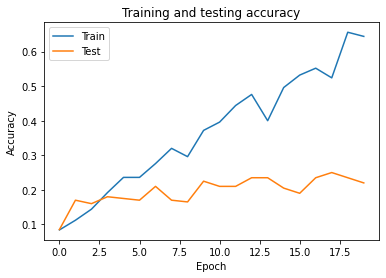

In [16]:
plt.plot(history_mlp.history['accuracy'], label='Train')
plt.plot(history_mlp.history['val_accuracy'], label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and testing accuracy')
plt.legend()
plt.show()

In [ ]:
the reason why this mlp performs poor is: the model is too simple, the network is too simple ,
model is underfitting

3. To improve the performance of the above MLP, one strategy is to use features of the images as the input of the MLP to improve the performance.  How will you extract the features from the raw images?  Implement the feature extraction and classification on the given dataset, and plot the training accuracy and testing accuracy under different epochs. Please see the assignment specificication for more details of the training settings.

In [17]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np

In [66]:
deep_model = VGG19(weights='imagenet', input_shape=[32,32,3],include_top=False,classifier_activation="softmax")
modelvgg = Model(inputs=deep_model.input, outputs=deep_model.get_layer('block5_conv4').output)


In [67]:
vgg_train=modelvgg.predict(train_images_sub)
vgg_test=modelvgg.predict(test_images_sub)

In [68]:
input_layer1 = Input(shape=(2, 2, 512))
x1 = Flatten()(input_layer1)
x1 = Dense(256, activation='relu', name='FC256')(x1)
x1 = Dense(10, activation='softmax', name='FC10')(x1)

In [69]:
fea_MLP = Model(input_layer1, x1, name='fea_mlp')

In [70]:
fea_MLP.compile(optimizer='adam',
           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), #use SparseCategoricalCrossentropy because labels are integers. If the labels are one-hot representation, please use CategoricalCrossentropy loss.
           metrics=['accuracy'])

In [71]:
history_bettermlp= fea_MLP.fit(vgg_train, train_labels_sub, epochs=20, batch_size=32, 
                    validation_data=(vgg_test, test_labels_sub))

Epoch 1/20
8/8 [==============================] - 0s 16ms/step - loss: 14.7284 - accuracy: 0.2000 - val_loss: 11.3093 - val_accuracy: 0.3300
Epoch 2/20
8/8 [==============================] - 0s 6ms/step - loss: 2.2775 - accuracy: 0.7320 - val_loss: 10.0618 - val_accuracy: 0.3550
Epoch 3/20
8/8 [==============================] - 0s 7ms/step - loss: 0.5041 - accuracy: 0.9200 - val_loss: 10.0796 - val_accuracy: 0.3850
Epoch 4/20
8/8 [==============================] - 0s 6ms/step - loss: 0.1152 - accuracy: 0.9640 - val_loss: 10.6306 - val_accuracy: 0.3850
Epoch 5/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0773 - accuracy: 0.9760 - val_loss: 10.5661 - val_accuracy: 0.3850
Epoch 6/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0114 - accuracy: 0.9960 - val_loss: 10.5563 - val_accuracy: 0.3750
Epoch 7/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 10.5581 - val_accuracy: 0.3800
Epoch 8/20
8/8 [=========

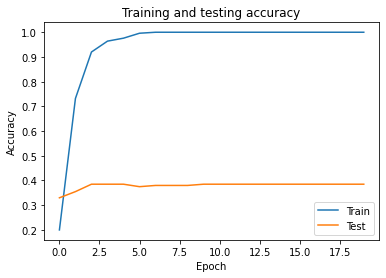

In [72]:
plt.plot(history_bettermlp.history ['accuracy'], label='Train')
plt.plot(history_bettermlp.history ['val_accuracy'], label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and testing accuracy')
plt.legend()
plt.show()

In [ ]:
I use a deep CNN (VGG19) pre-trained on Imagenet for feature extraction and use MLP for classification
After crossing the vgg19 layer, use the output of the "conv5_block4_out" layer as the feature output.
The reason why this method can improve the accuracy of MLP testing is
It can extract more advanced features from the original pixels, and these high-dimensional features can capture
The difference between each category. The deep pre-trained network can support the comparison of images with existing imagenet to improve accuracy
And provide a Dropout method to prevent overfitting of the model,
